In [1]:
import matplotlib.pyplot as plt
import numpy as np
import util
import xarray as xr
from matplotlib import colors, ticker
from matplotlib.gridspec import GridSpec
from scipy import stats

chunks = {"x": 2000, "ncol": 2000}
t = -6

In [2]:
run = "dpscream_rce_large_3km_aa_default"
run_dir = f"/glade/derecho/scratch/sturbeville/DPSCREAM_simulations/{run}/run/"
file = run_dir + f"{run}_h0_last5days.nc"
qsmall=1e-8

In [3]:
plt.rcParams.update({"font.size": 18})  # all to 18 if not specified other

In [4]:
print(file)
ds = xr.open_dataset(file, chunks=chunks)[["crm_grid_x", "crm_grid_y", "CLDICE", "CLDLIQ"]].isel(
    time=t
)  # .isel(time=slice(-20,-1))
x = ds.crm_grid_x
y = ds.crm_grid_y
iwc = ds.CLDICE+ds.CLDLIQ
time = ds.time
del ds
print(x.shape, y.shape, time.values)

/glade/derecho/scratch/sturbeville/DPSCREAM_simulations/dpscream_rce_large_3km_aa_default/run/dpscream_rce_large_3km_aa_default_h0_last5days.nc
(147456,) (147456,) 2000-02-18 18:00:00


In [5]:
cross_mask = np.where(x < 1, 1, 0)
print(cross_mask.shape)
x0 = x.where(cross_mask)
y0 = y.where(cross_mask)
print(x0.shape, y0.shape)
ncross = np.nansum(cross_mask)
print(ncross)

(147456,)
(147456,) (147456,)
1536


/glade/u/apps/opt/conda/envs/npl-2024b/lib/python3.11/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in log10
  return func(*(_execute_task(a, cache) for a in args))


In [6]:
nuc = (
    xr.open_dataset(run_dir + run + "_NUC_hrs.nc").sel(time=time, method="nearest").NUC
)
bcu = (
    xr.open_dataset(run_dir + run + "_BCU_hrs.nc").sel(time=time, method="nearest").BCU
)
z = (
    xr.open_dataset(run_dir + run + "_Zmean_last5days.nc")
    .sel(time=time, method="nearest")
    .Z3[0, :, 0]
)
print(time.values, nuc.time.values)
nuc

2000-02-18 18:00:00 2000-02-18 18:00:00


<xarray.DataArray 'NUC' (lev: 128, x: 147456)> Size: 75MB
[18874368 values with dtype=float32]
Coordinates:
    time     object 8B 2000-02-18 18:00:00
  * lev      (lev) float64 1kB 2.58 3.23 3.88 4.597 ... 987.2 991.0 994.9 998.5
Dimensions without coordinates: x
Attributes:
    long_name:     Nucleation tracer
    units:         kg/kg
    mdims:         1
    mixing_ratio:  dry
    cell_methods:  time: point

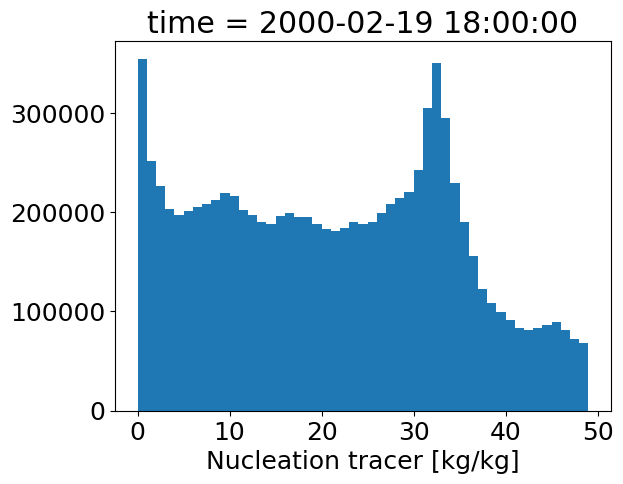

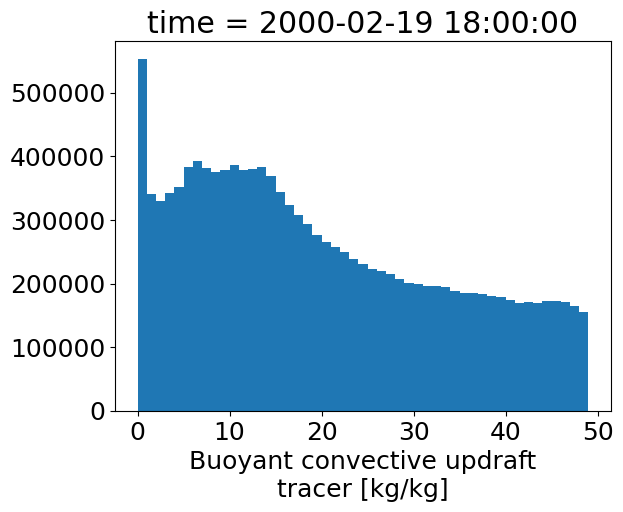

In [9]:
nuc.plot.hist(bins=np.arange(0, 50))
plt.show()
bcu.plot.hist(bins=np.arange(0, 50))
plt.show()

In [7]:
# plt.scatter(y0/1000, x0)
# plt.show()

In [8]:
# y_plot = np.linspace(0,y[-1].values,ncross)
# print(y_plot.shape)

In [9]:
iwc_plot = iwc.where(cross_mask[np.newaxis, :])
nuc_plot = nuc.where((iwc>qsmall)&(cross_mask[np.newaxis, :]))
bcu_plot = bcu.where((iwc>qsmall)&(cross_mask[np.newaxis, :]))
cld_plot = np.where(bcu_plot<2,2,0)+np.where(nuc_plot<(bcu_plot),1,0)
cld_plot

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [10]:
y.shape, z.shape, iwc_plot.shape, nuc_plot.shape, bcu_plot.shape, cld_plot.shape

((147456,), (128,), (128, 147456), (128, 147456), (128, 147456), (128, 147456))

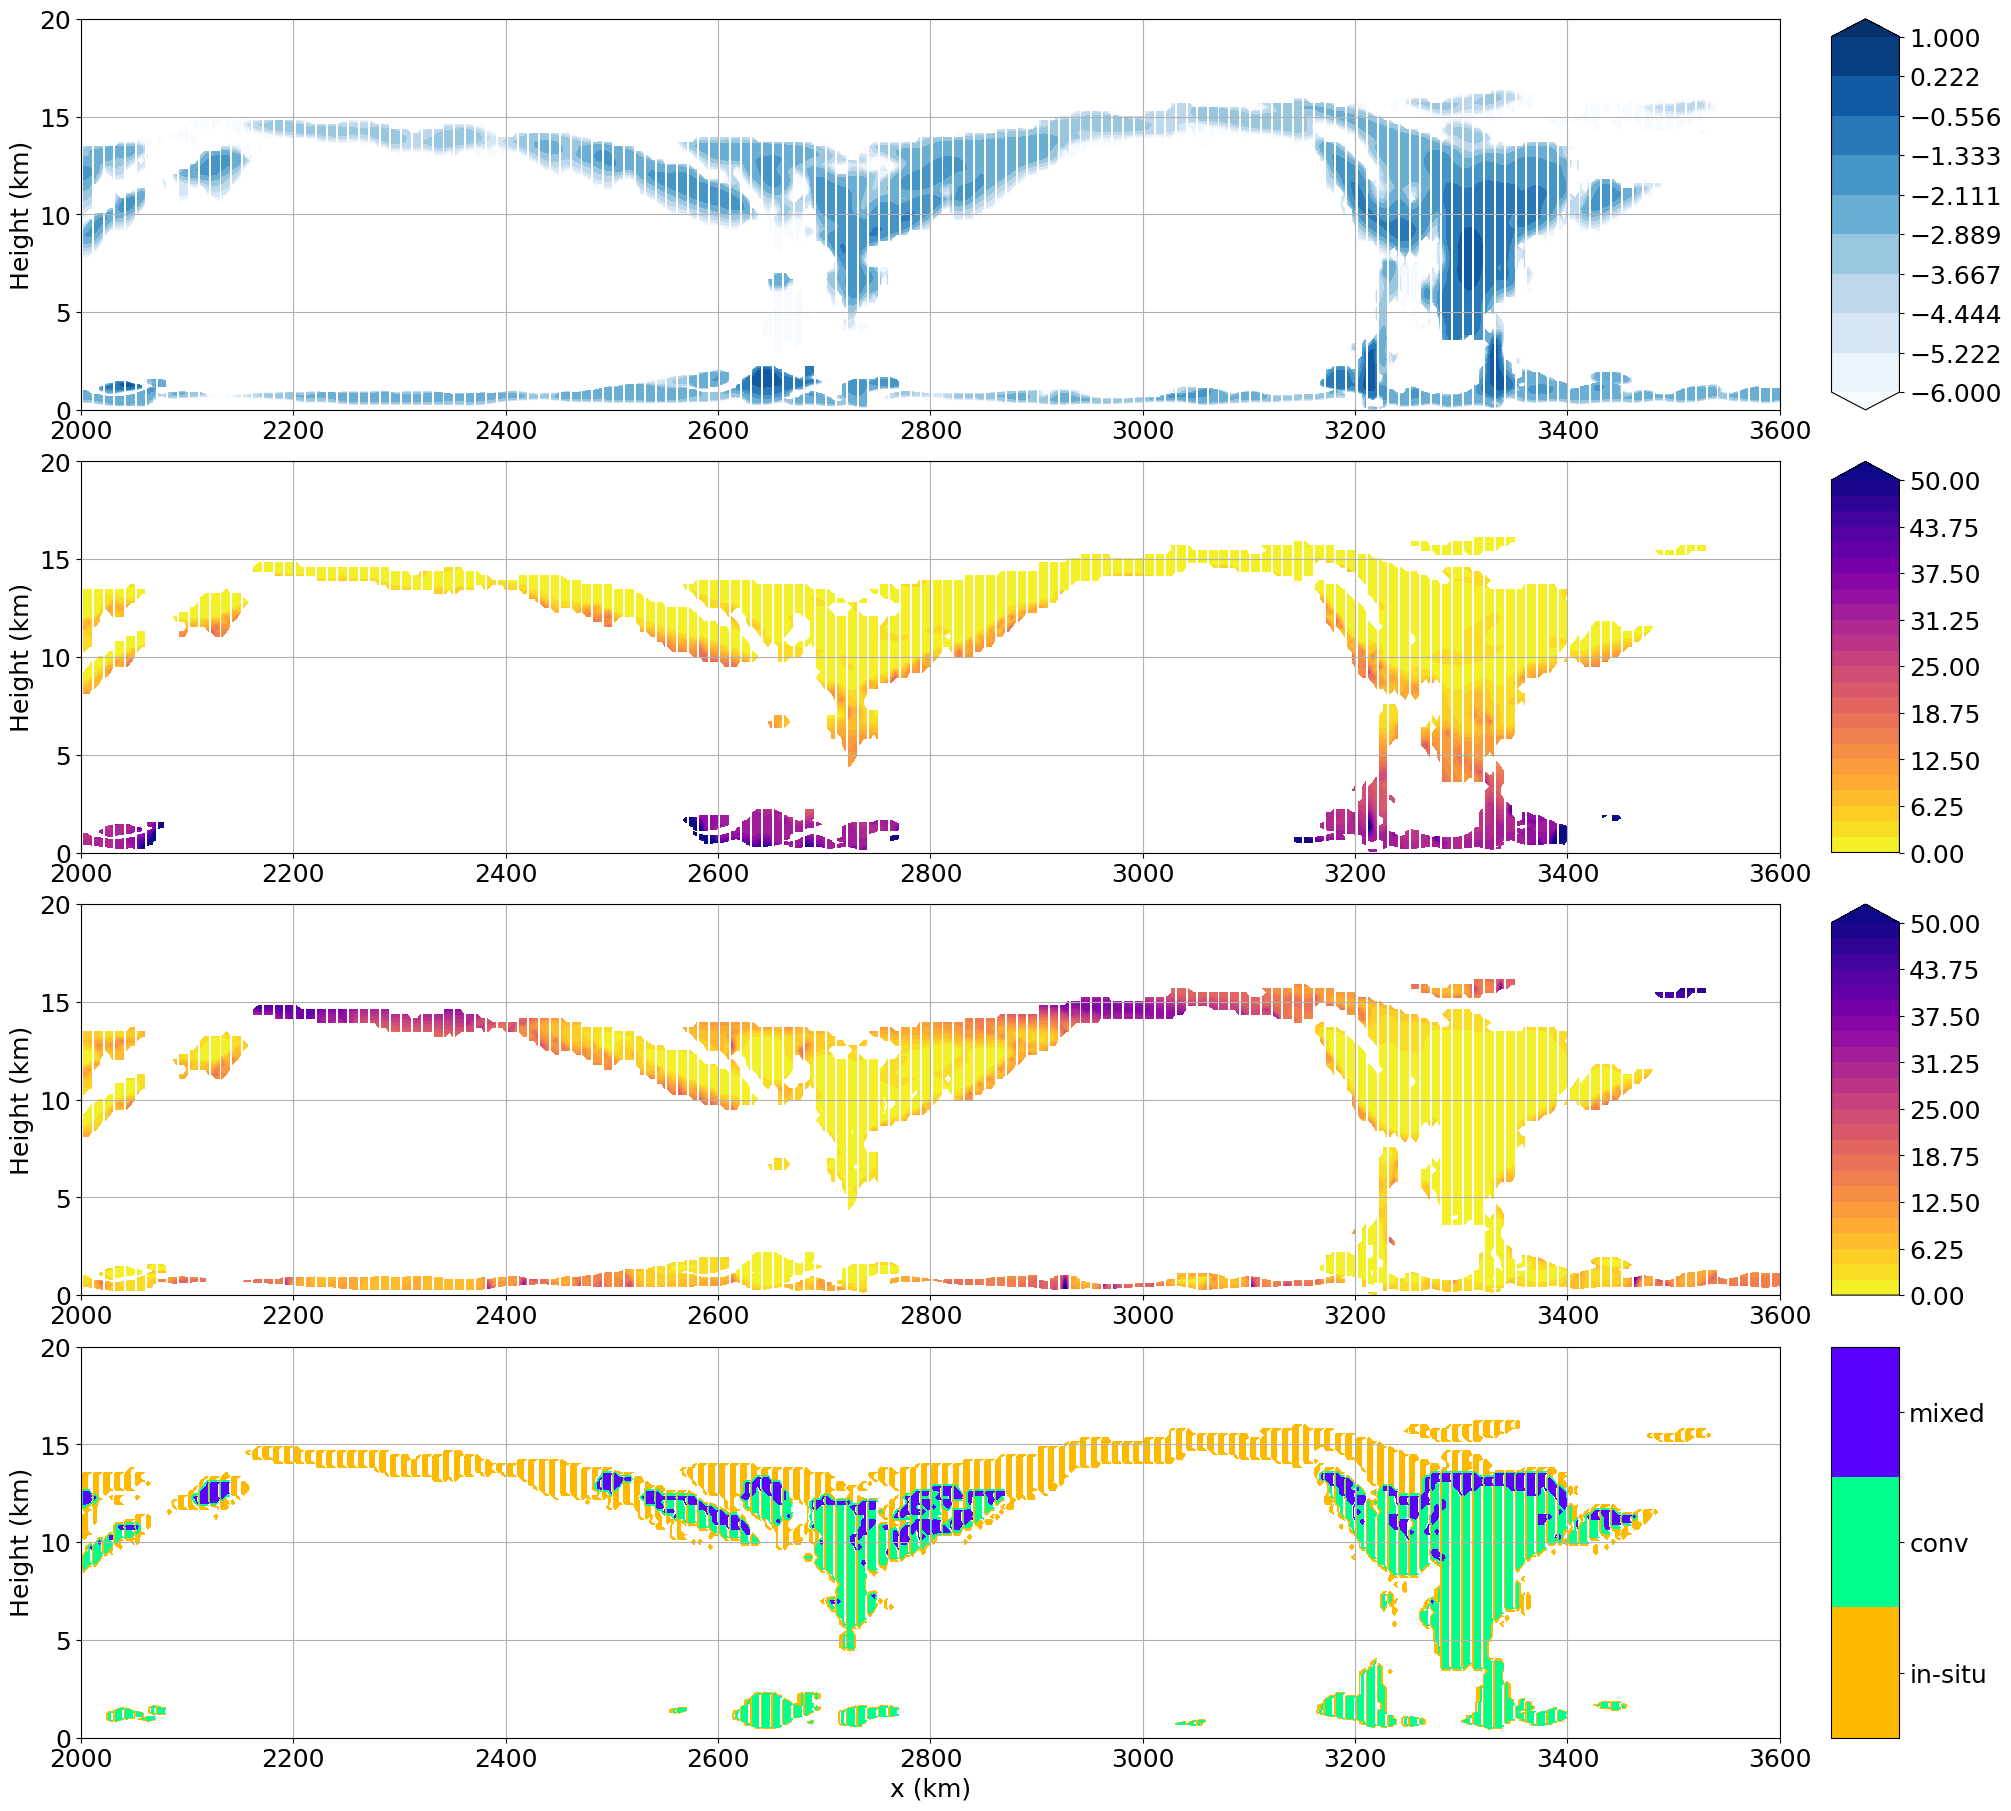

In [11]:
fig = plt.figure(figsize=(20, 18), layout="constrained")
gs = GridSpec(4, 2, figure=fig, width_ratios=[100, 4], hspace=0)
ax0 = fig.add_subplot(gs[0, 0])
cax0 = fig.add_subplot(gs[0, 1])
cf = ax0.contourf(
    y / 1000,
    z / 1000,
    np.log10(iwc_plot * 1000),
    levels=np.linspace(-6, 1, 10),
    extend="both",
    cmap="Blues",
)
plt.colorbar(cf, cax=cax0, extend="both")
ax1 = fig.add_subplot(gs[1, 0])
cax1 = fig.add_subplot(gs[1, 1])
cf = ax1.contourf(
    y / 1000,
    z / 1000,
    nuc_plot,
    levels=np.linspace(0, 50, 25),
    extend="max",
    cmap="plasma_r",
)
plt.colorbar(cf, cax=cax1)
ax2 = fig.add_subplot(gs[2, 0])
cax2 = fig.add_subplot(gs[2, 1])
cf = ax2.contourf(
    y / 1000,
    z / 1000,
    bcu_plot,
    levels=np.linspace(0, 50, 25),
    extend="max",
    cmap="plasma_r",
)
plt.colorbar(cf, cax=cax2)
ax3 = fig.add_subplot(gs[3, 0])
cax3 = fig.add_subplot(gs[3, 1])
cf = ax3.contourf(
    y / 1000,
    z / 1000,
    cld_plot,
    levels=np.arange(0.5, 3.6, 1),
    extend="neither",
    cmap="gist_rainbow",
)
cbar = plt.colorbar(cf, cax=cax3, ticks=[1,2,3])
cbar.ax.set_yticklabels(["in-situ","conv","mixed"])

ax0.set(ylim=[0, 20], xlim=[2000,3600], ylabel="Height (km)")
ax1.set(ylim=[0, 20], xlim=[2000,3600], ylabel="Height (km)")
ax2.set(ylim=[0, 20], xlim=[2000,3600], ylabel="Height (km)")
ax3.set(ylim=[0, 20], xlim=[2000,3600], ylabel="Height (km)", xlabel="x (km)")
ax0.grid(True)
ax1.grid(True)
ax2.grid(True)
ax3.grid(True)
plt.savefig(f"../plots/movie/cross_section/cross_section_zoomedx_{t:04d}.png")
plt.show()